# Clustering & Topic Modeling

## Clustering emails using Gaussian Mixture Models

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Construct a list of processed documents

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################

import os
os.chdir('/dataset')

processed_documents = []

for filename in os.listdir('data/enron'):
    file_path = os.path.join('data/enron', filename)
    processed_doc = make_word_list(file_path)
    processed_documents.append(processed_doc)


### Construct a document matrix

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [4]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50, max_df=0.8, stop_words='english')

X = vectorizer.fit_transform(processed_documents)

print("Number of unique words in the vocabulary:", len(vectorizer.vocabulary_))

Number of unique words in the vocabulary: 1680


### Clustering

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [5]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0)

gmm.fit(X.toarray())  

clusters = gmm.predict(X.toarray())

cluster_counts = {i: list(clusters).count(i) for i in range(3)}

for cluster, count in cluster_counts.items():
    print(f"Number of documents in cluster {cluster}: {count}")

Number of documents in cluster 0: 3819
Number of documents in cluster 1: 763
Number of documents in cluster 2: 590


### Characterize the clusters

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [6]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

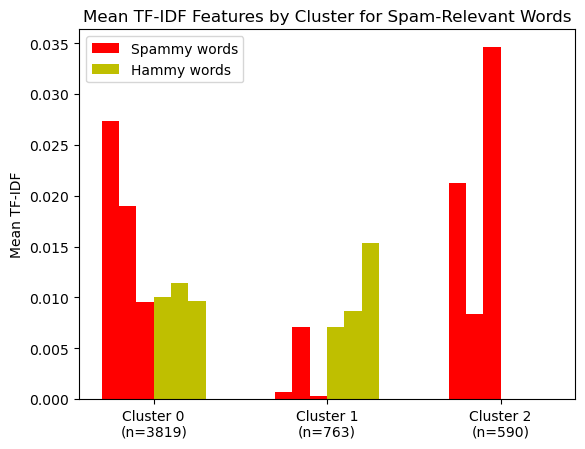

In [7]:
########################################################################
######################### Write your code here #########################
########################################################################

vocabulary = vectorizer.vocabulary_

# Selecting spammy and hammy words
spammy_words = ['click', 'www', 'offer']
hammy_words = ['meeting', 'attached', 'review']

spam_indices = [vocabulary[word] for word in spammy_words if word in vocabulary]
ham_indices = [vocabulary[word] for word in hammy_words if word in vocabulary]

plot_spam_words_by_cluster(X, clusters, 3, spam_indices, ham_indices)

### Interpreting results

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

Cluster 0: Shows a higher mean TF-IDF for spammy words compared to hammy words. This suggests that Cluster 0 may correspond to spam emails since spammy words are more prominent.

Cluster 1: Has lower mean TF-IDF values for both spammy and hammy words, with hammy words slightly more represented than spammy words. This cluster might be harder to categorize solely based on this information, but it might contain a mix of emails or those that don't heavily use either set of words.

Cluster 2: Exhibits a significantly higher mean TF-IDF for spammy words and a negligible presence of hammy words. This is a strong indicator that Cluster 2 predominantly contains spam emails.

For typical business emails (ham), we would expect a cluster to have a higher mean TF-IDF for hammy words than spammy words. Cluster 1 could potentially correspond to this, but the evidence is not as strong as it is for the spam clusters.

Increasing the number of clusters (e.g., to 5) leads to a more nuanced separation of emails, potentially distinguishing between different types of spam or business emails.

Decreasing the number of clusters (e.g., to 2) provides a broader categorization, which makes it easier to distinguish between spam and ham overall, but with less nuance.

Therefore, increasing the number of clusters can be advantageous for achieving more precise analysis results.

/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_base.py:651: RuntimeWarning: divide by zero encountered in true_divide
  return self.astype(np.float_)._mul_scalar(1./other)


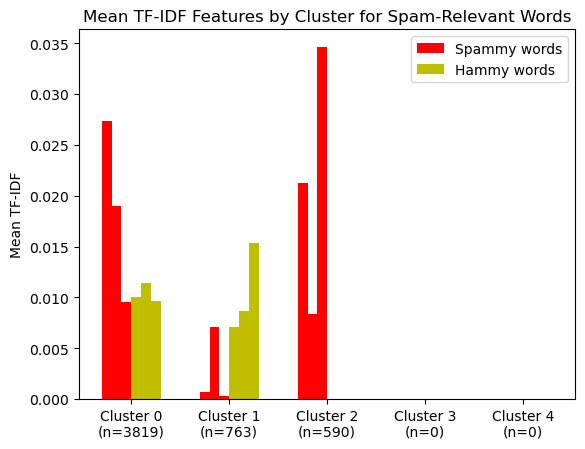

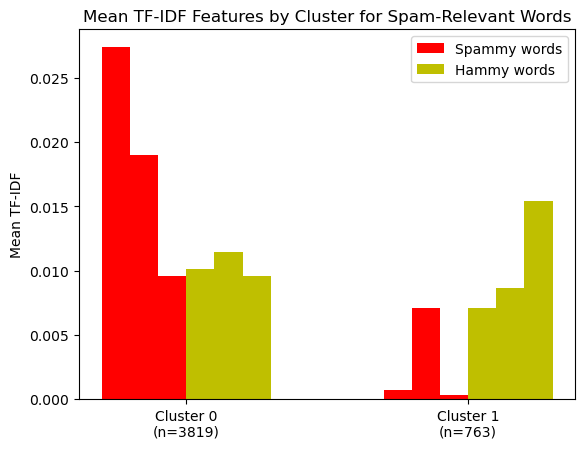

In [8]:
########################################################################
######################### Write your code here #########################
########################################################################

plot_spam_words_by_cluster(X, clusters, 5, spam_indices, ham_indices)

plot_spam_words_by_cluster(X, clusters, 2, spam_indices, ham_indices)

## Latent "Purposes" in Mobile Apps


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Load the data

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [10]:
df = pd.read_csv("/Users/siddhesh/Downloads/android.csv", sep=",",  thousands=",")

In [11]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [12]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Convert each app into a "document"

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [13]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

### Downweight "stopwords"

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [14]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X)

### Discover 10 "topics"

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).

In [15]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, max_iter=10, n_jobs=-1, random_state=0)

lda.fit(X_tfidf)

CPU times: user 4.01 s, sys: 298 ms, total: 4.31 s
Wall time: 22.6 s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### List the top 10 "words" in each topic

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [16]:
########################################################################
######################### Write your code here #########################
########################################################################

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print_top_words(lda, permission_columns, 10)

Topic #0: Your location : coarse (network-based) location (D), Your location : fine (GPS) location (D), Network communication : full Internet access (D), Network communication : view network state (S), Phone calls : read phone state and identity (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Services that cost you money : directly call phone numbers (D), Your personal information : read sensitive log data (D), Network communication : view Wi-Fi state (S), Default : access checkin properties (S)
Topic #1: Hardware controls : control vibrator (S), Network communication : full Internet access (D), Network communication : view network state (S), Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : disable keylock (D), Phone calls : read phone state and identity (D), System tools : prevent device from sleeping (D), Hardware controls : change your audio settings (D), Default : modify battery statistics (S), Sys

*** WRITE YOUR ANSWER HERE IN TEXT ***

Topic #0: Likely a location-based service app, such as mapping or ride-sharing, needing access to location, network, and storage.

Topic #1: Seems to be for a multimedia or alarm app, given permissions like controlling the vibrator, changing audio settings, and disabling keylock.

Topic #2: Could be a financial management app, as indicated by the Google Finance permission, along with access to contacts and accounts.

Topic #5: Appears to be a photo editing or gallery app, with permissions to modify storage, set wallpapers, and take pictures/videos.

Topic #6: Likely a camera or recording app, given permissions for taking pictures, recording audio, and accessing location.

Topic #7: Suggests a network or connectivity management app, focusing on Wi-Fi and Bluetooth settings.

### For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [17]:
########################################################################
######################### Write your code here #########################
########################################################################

high_rating_indices = [i for i, n in enumerate(app_ratings) if n >= 100000]
high_rating_app_names = [app_names[i] for i in high_rating_indices]
X_high_rating = X_tfidf[high_rating_indices, :]

topic_distributions = lda.transform(X_high_rating)

top_apps_by_topic = {}
for topic_idx in range(10):
    apps_sorted_by_topic = topic_distributions[:, topic_idx].argsort()[::-1]
    
    top_3_indices = apps_sorted_by_topic[:3]
    top_3_apps = [high_rating_app_names[i] for i in top_3_indices]
    
    top_apps_by_topic[topic_idx] = top_3_apps

for topic, apps in top_apps_by_topic.items():
    print(f"Topic #{topic}: {', '.join(apps)}")


Topic #0: Dictionary.com, Air Control Lite, Paper Toss
Topic #1: Live Holdem Poker Pro, Vaulty Free Hides Pictures, Drag Racing
Topic #2: Angry Birds Seasons, Yoo Ninja! Free, Adobe Reader
Topic #3: Lookout Security & Antivirus, Antivirus Free, Skype
Topic #4: Real BlackJack, Alchemy, Tank Hero
Topic #5: World Newspapers, Paradise Island, My Country
Topic #6: Brightest Flashlight Free™, Brightest Flashlight Free???, Tiny Flashlight + LED
Topic #7: Slice It!, Racing Moto, Blast Monkeys
Topic #8: TuneIn Radio, Restaurant Story™, Restaurant Story???
Topic #9: chompSMS, Ringdroid, Google Sky Map


### Visualize the document-topic proportion matrix in 2-D using t-SNE

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

/Users/siddhesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


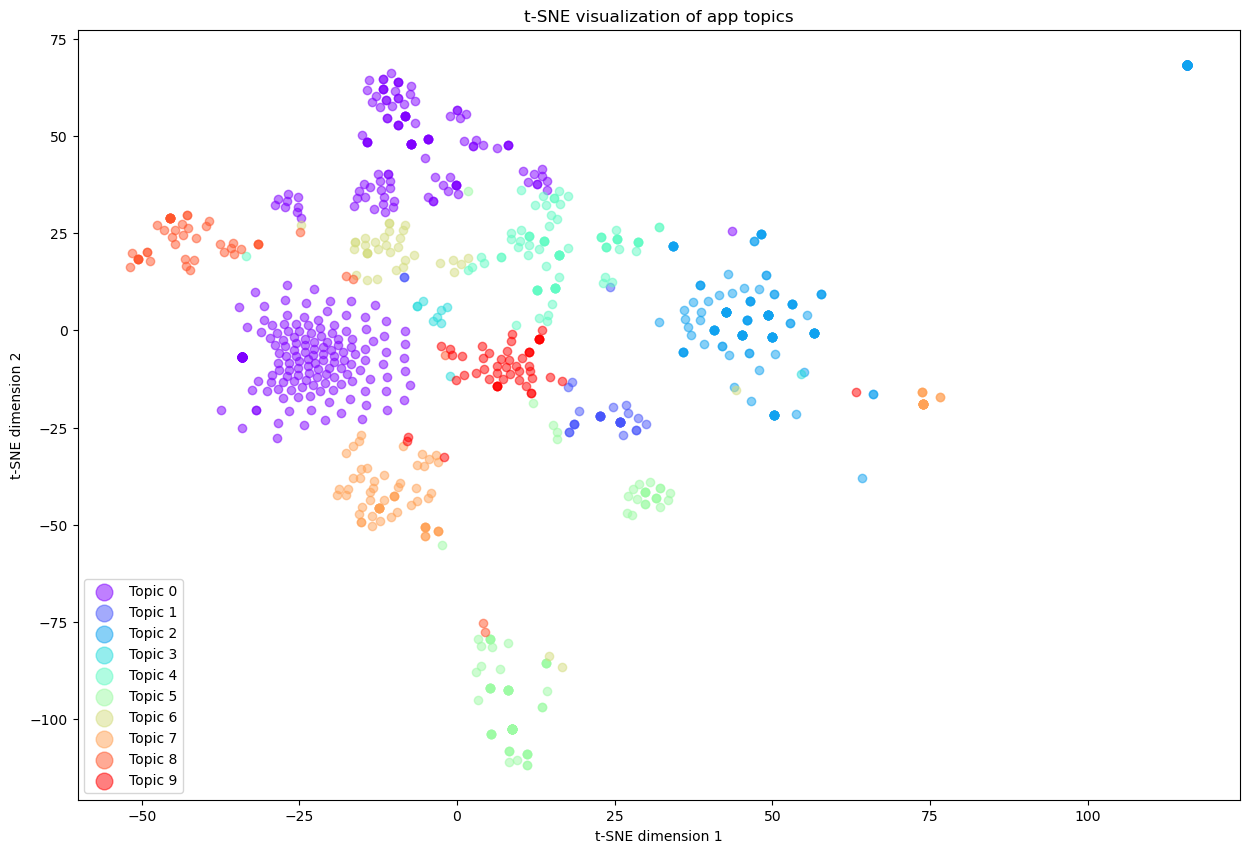

CPU times: user 10.6 s, sys: 1.66 s, total: 12.3 s
Wall time: 2.57 s


In [18]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.manifold import TSNE

np.random.seed(0) 
sample_indices = np.random.choice(X.shape[0], size=1000, replace=False)
X_sample = X[sample_indices, :]
app_names_sample = [app_names[i] for i in sample_indices]

topic_distributions_sample = lda.transform(X_sample)

tsne_model = TSNE(n_components=2, angle=0.99, init='pca', learning_rate=200, random_state=0)
X_tsne = tsne_model.fit_transform(topic_distributions_sample)

colors = plt.cm.rainbow(np.linspace(0, 1, 10))

most_probable_topics = np.argmax(topic_distributions_sample, axis=1)

plt.figure(figsize=(15, 10))
for topic_idx, color in enumerate(colors):
    indices = most_probable_topics == topic_idx
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=[color], label=f'Topic {topic_idx}', alpha=0.5)

plt.title('t-SNE visualization of app topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(markerscale=2)
plt.show()